In [1]:
import os
import pycolmap
import pathlib
import numpy as np
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt



In [2]:
IMAGES_DIR = "frames"
OUTPUT_PATH = "colmap_output"

output_path = pathlib.Path(OUTPUT_PATH)
image_dir = pathlib.Path(IMAGES_DIR)

# [10 %] Run Colmap (https://github.com/colmap/colmap.git) to get the initial point cloud.

In [ ]:

mvs_path = output_path / "mvs"
database_path = output_path / "database.db"

## THIS RUNS COLMAP, SO IS COMMENTED

# pycolmap.extract_features(database_path, image_dir)
# pycolmap.match_exhaustive(database_path)
# maps = pycolmap.incremental_mapping(database_path, image_dir, output_path)
# maps[0].write(output_path)
# # dense reconstruction
# pycolmap.undistort_images(mvs_path, output_path, image_dir)
# pycolmap.patch_match_stereo(mvs_path)  # requires compilation with CUDA
# pycolmap.stereo_fusion(mvs_path / "dense.ply", mvs_path)


## Visualize dense points

In [ ]:
import numpy as np
import viser
from pathlib import Path
from plyfile import PlyData

ply_path = Path("colmap_output/mvs/dense.ply") 
ply_data = PlyData.read(str(ply_path))

vertex = ply_data['vertex']
points = np.column_stack([vertex['x'], vertex['y'], vertex['z']])
colors = np.column_stack([vertex['red'], vertex['green'], vertex['blue']]).astype(np.uint8)

server = viser.ViserServer()

point_cloud = server.scene.add_point_cloud(
    name="/dense_cloud",
    points=points,
    colors=colors,
    point_size=0.05,
)

print(f"Dense reconstruction: {points.shape[0]} points")

point_size_slider = server.gui.add_slider(
    label="Point Size",
    min=0.001,
    max=0.5,
    step=0.001,
    initial_value=0.05,
)

@point_size_slider.on_update
def _(_) -> None:
    point_cloud.point_size = point_size_slider.value

while True:
    pass

## Visualize sparse point cloud

In [ ]:
import numpy as np
import viser
import pycolmap
from pathlib import Path

sparse_path = Path("colmap_output/mvs/sparse")

reconstruction = pycolmap.Reconstruction(str(sparse_path))

points_list = []
colors_list = []

for point_id, p in reconstruction.points3D.items():
    points_list.append(p.xyz)                    # (x, y, z)
    colors_list.append(p.color)                 # (r, g, b)

points = np.array(points_list)
colors = np.array(colors_list, dtype=np.uint8)

print(f"Sparse reconstruction: {points.shape[0]} points")

server = viser.ViserServer()

pc = server.scene.add_point_cloud(
    name="/sparse_cloud",
    points=points,
    colors=colors,
    point_size=0.03,
)

slider = server.gui.add_slider(
    label="Sparse Point Size",
    min=0.001,
    max=0.5,
    step=0.001,
    initial_value=0.03,
)

@slider.on_update
def _(_ev):
    pc.point_size = slider.value

while True:
    pass


# [60 %] Using the python binding of Colmap (https://github.com/colmap/colmap/tree/main/pycolmap), read the database and split the model into the foreground (your object) and background models.

## Use off-the-shelf segmentation model sam2 and segment out the object of interest.  Note that segmentation masks might not be 100% precise; you would need to aggregate foreground vs background counts estimated from different views for each 3d point.

In [3]:
import sys
sys.path.append("sam2/")

import torch
from sam2.build_sam import build_sam2_video_predictor


# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

sam2_checkpoint = "sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

/home/julfy/Documents/5th_term/cv/.venv_general_cv/lib/python3.12/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
video_dir = str(mvs_path / "images_jpg")
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

frame loading (JPEG): 100%|██████████| 98/98 [00:02<00:00, 40.70it/s]


In [8]:
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))


In [9]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

/home/julfy/Documents/5th_term/cv/homework3/sam2/sam2/sam2_video_predictor.py:786: UserWarning: inputs.is_cuda() INTERNAL ASSERT FAILED at "/home/julfy/Documents/5th_term/cv/homework3/sam2/sam2/csrc/connected_components.cu":215, please report a bug to PyTorch. inputs must be a CUDA tensor

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


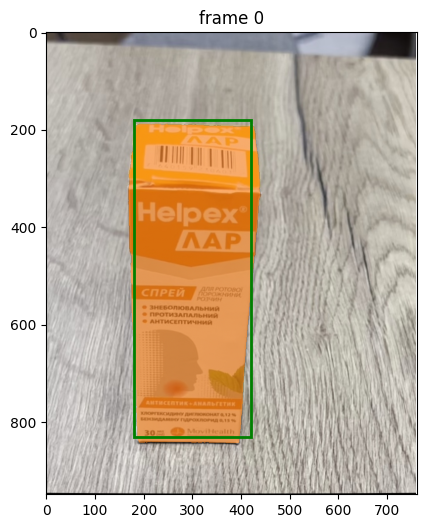

In [ ]:
## code from SAM2 docs

from PIL import Image

ann_frame_idx = 0
ann_obj_id = 1

box = np.array([180, 180, 420, 830], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|██████████| 98/98 [04:56<00:00,  3.03s/it]


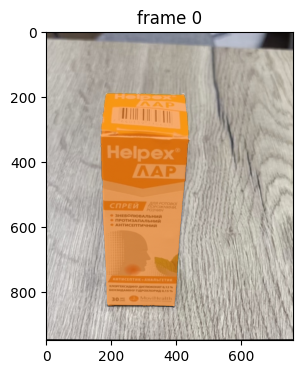

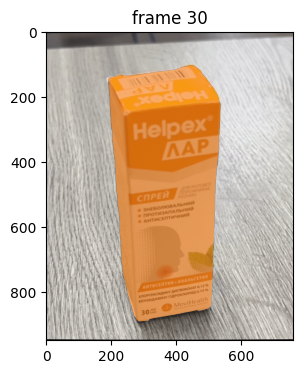

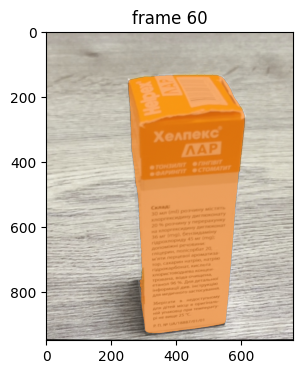

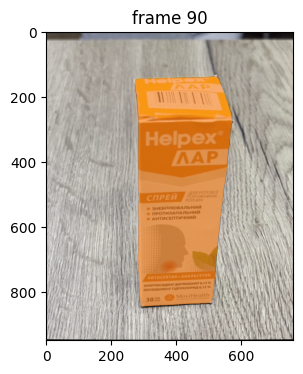

In [ ]:
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

In [ ]:
video_segments.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97])

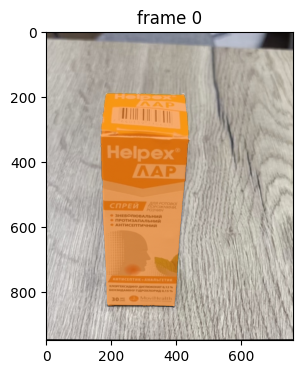

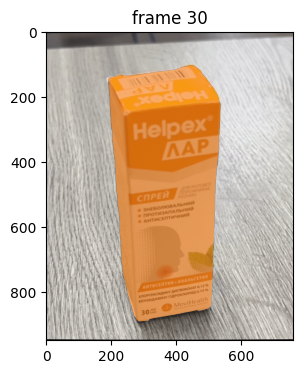

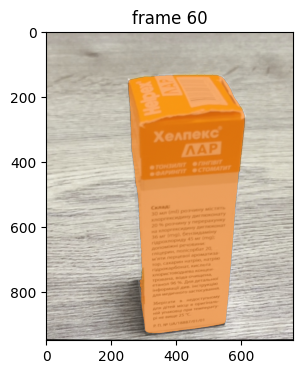

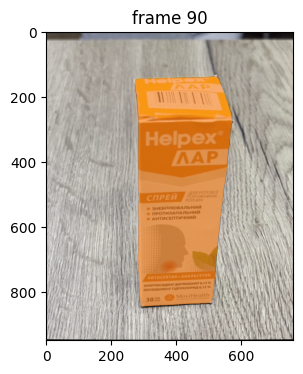

In [16]:
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [51]:

def get_segment(video_segments, index):

    segment = video_segments[index][1][0]

    return segment


    

In [52]:
image_shape = video_segments[0][1][0].shape
voting_threshold = 0.9
sparse_path = pathlib.Path("colmap_output/mvs/sparse")

reconstruction = pycolmap.Reconstruction(str(sparse_path))

p3d_to_observations = defaultdict(list)

sorted_images = sorted(reconstruction.images.values(), key=lambda img: img.name)



for index, image in enumerate(sorted_images):
    segmentation = get_segment(video_segments, index)
        
    for p2d_idx, p2d in enumerate(image.points2D):
        if p2d.has_point3D():
            xy = p2d.xy
            x, y = tuple(xy.astype(int))
            if (image_shape[0] > y and image_shape[1] > x): ## some are out of bounce
                semantics = segmentation[y][x]
                p3d_to_observations[p2d.point3D_id].append(semantics) ## add if the 3d point is in object mask or not
p3d_to_fused = {k: np.mean(v, 0) for k, v in p3d_to_observations.items()}  # fuse the semantic probs
valid_p3d_ids = set(key for key, value in p3d_to_fused.items() if value > voting_threshold)
print(f"Saved {len(valid_p3d_ids)} valid 3d points!")

Saved 18776 valid 3d points!


### Apply segmented region to point cloud

In [53]:
import numpy as np
from plyfile import PlyData, PlyElement

filteres_sparse_point_save_path = "colmap_output/sam2_filtered_sparse.ply"

points = []
colors = []

for p3d_id, p3d in reconstruction.points3D.items():
    if (not p3d_id in valid_p3d_ids):
        continue
    points.append(p3d.xyz)
    colors.append(p3d.color)
        

points = np.array(points)
colors = np.array(colors)

vertex = np.array(
    list(zip(points[:,0], points[:,1], points[:,2], colors[:,0], colors[:,1], colors[:,2])),
    dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'), 
           ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
)

el = PlyElement.describe(vertex, 'vertex')
PlyData([el]).write(filteres_sparse_point_save_path)

print(f"Saved {filteres_sparse_point_save_path}!")

Saved colmap_output/sam2_filtered_sparse.ply!


In [54]:
import numpy as np
import viser
from pathlib import Path
from plyfile import PlyData

ply_data = PlyData.read(filteres_sparse_point_save_path)

vertex = ply_data['vertex']
points = np.column_stack([vertex['x'], vertex['y'], vertex['z']])
colors = np.column_stack([vertex['red'], vertex['green'], vertex['blue']]).astype(np.uint8)

server = viser.ViserServer()

point_cloud = server.scene.add_point_cloud(
    name="/dense_cloud",
    points=points,
    colors=colors,
    point_size=0.05,
)

print(f"Reconstruction: {points.shape[0]} points")

point_size_slider = server.gui.add_slider(
    label="Point Size",
    min=0.001,
    max=0.5,
    step=0.001,
    initial_value=0.05,
)

@point_size_slider.on_update
def _(_) -> None:
    point_cloud.point_size = point_size_slider.value

while True:
    pass

╭────── viser (listening *:8082) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8082   │
│   Websocket │ ws://localhost:8082     │
│             ╵                         │
╰───────────────────────────────────────╯

Reconstruction: 18776 points


(viser) Connection opened (0, 1 total), 8 persistent messages

(viser) Connection closed (0, 0 total)

KeyboardInterrupt: 